In [1]:
!pip3 install pronouncing
!pip3 install markovify
!pip3 install textstat

In [2]:
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Conv1D, Embedding, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import pdist, squareform
from better_profanity import profanity
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rand
import numpy as np
import pronouncing
import markovify
import textstat
import math

In [ ]:
artist_file = "./data/Drake_lyrics.txt"
artist_lyrics = []

with open(artist_file, "r") as file:
    song = profanity.censor(file.read())
    artist_lyrics = song.replace('\ufeff', '').split("\n")

print(artist_lyrics)

In [7]:
markov_model = markovify.NewlineText(str("\n".join(artist_lyrics)), well_formed=False, state_size=3)

In [8]:
sentence = markov_model.make_sentence(tries=100)

print(sentence)

# Test out the readability index
print(textstat.automated_readability_index(sentence))

Back to back, like I'm on the road right now swangin, girl
3.0


In [9]:
# Train datasets
sequences = artist_lyrics

# Tokenize for TensorFlow
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sequences)
V = len(tokenizer.word_index)+1

# Pad the sequences
seq = pad_sequences(tokenizer.texts_to_sequences(sequences), maxlen=30)

# Split to X/y data
train_X, train_y = seq[:, :-1], tf.keras.utils.to_categorical(seq[:, -1], num_classes=V)

print(train_X.shape, train_y.shape)

(4244, 29) (4244, 3307)


In [10]:
D = 512

#Simple RNN
T = train_X.shape[1]
i = Input(shape=(T,))
x = Embedding(V, D)(i)
x = Dropout(0.2)(x)
x = SimpleRNN(150)(x)
x = Dense(V, activation="softmax")(x)
rnn_model = Model(i, x)
rnn_model.summary()

adam = tf.keras.optimizers.Adam(learning_rate=0.001)

rnn_model.compile(optimizer=adam, metrics=["accuracy"], loss="categorical_crossentropy")

rnn_r = rnn_model.fit(train_X, train_y, epochs=50)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 29, 512)           1693184   
_________________________________________________________________
dropout (Dropout)            (None, 29, 512)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 150)               99450     
_________________________________________________________________
dense (Dense)                (None, 3307)              499357    
Total params: 2,291,991
Trainable params: 2,291,991
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
133/133 [==============================] - 15s 92ms/step - loss: 6.6316 - accuracy: 0.0994
Epoch 2/50
133/

In [11]:
D = 768

T = train_X.shape[1]
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Dropout(0.1)(x)
x = LSTM(100, return_sequences=True)(x)
x = LSTM(100)(x)
x = Dropout(0.1)(x)
x = Dense(V, activation="softmax")(x)
lstm_model = Model(i, x)
lstm_model.summary()


adam = tf.keras.optimizers.Adam(0.001)

lstm_model.compile(optimizer=adam, metrics=["accuracy"], loss="categorical_crossentropy")

lstm_r = lstm_model.fit(train_X, train_y, epochs=100)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 29, 768)           2540544   
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 768)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 29, 100)           347600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3307)              3340

In [13]:
D = 512

T = train_X.shape[1]
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Dropout(0.2)(x)
x = Conv1D(filters=512, kernel_size=15)(x)
x = Dropout(0.2)(x)
x = Conv1D(filters=256, kernel_size=8)(x)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(250))(x)
x = Dropout(0.2)(x)
x = Dense(V, activation="softmax")(x)
cnn_model = Model(i, x)
cnn_model.summary()

adam = tf.keras.optimizers.Adam(0.0001)

cnn_model.compile(optimizer=adam, metrics=["accuracy"], loss="categorical_crossentropy")

cnn_r = cnn_model.fit(train_X, train_y, epochs=220)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 29, 512)           1693696   
_________________________________________________________________
dropout_3 (Dropout)          (None, 29, 512)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 15, 512)           3932672   
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 512)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 256)            1048832   
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 256)            0   

KeyboardInterrupt: 

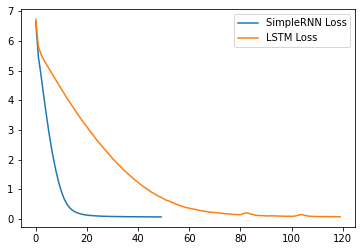

In [12]:
plt.plot(rnn_r.history['loss'], label="SimpleRNN Loss")
plt.plot(lstm_r.history['loss'], label="LSTM Loss")
plt.legend()

NameError: name 'cnn_r' is not defined

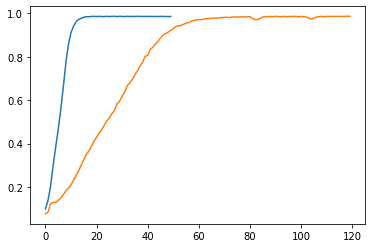

In [15]:
plt.plot(rnn_r.history['accuracy'], label="SimpleRNN accuracy")
plt.plot(lstm_r.history['accuracy'], label="LSTM accuracy")
plt.legend()

In [21]:
def generate_rap(model, artists_bars, length_of_bar=10, length_of_rap=20, min_score_threshold=-0.2, max_score_threshold=0.2, tries=5):
    artists_avg_readability = calc_readability(artists_bars)
    artists_avg_rhyme_idx = calc_rhyme_density(artists_bars)
    fire_rap = []
    cur_tries = 0
    candidate_bars = []

    while len(fire_rap) < length_of_rap:
        seed_phrase = markov_model.make_sentence(tries=500).split(" ")
        seed_phrase = " ".join(seed_phrase[:3])
        cur_tries += 1
        bar = generate_bar(seed_phrase, model, rand.randrange(4, length_of_bar))
        bar_score = score_bar(bar, artist_lyrics, artists_avg_readability, artists_avg_rhyme_idx) 
        candidate_bars.append((bar_score, bar))

    if bar_score <= max_score_threshold and bar_score >= min_score_threshold:
        fire_rap.append(bar)
        cur_tries = 0
    print("Generated Bar: ", len(fire_rap))

    if cur_tries >= tries:
        lowest_score = np.Infinity
        best_bar = ""
        for bar in candidate_bars:
            if bar[0] < lowest_score:
                best_bar = bar[1]
                candidate_bars = []
      
    print("Generated Bar: ", len(fire_rap))
    fire_rap.append(best_bar)
    cur_tries = 0
      
    print("Generated rap with avg rhyme density: ", calc_rhyme_density(fire_rap), "and avg readability of: ", calc_readability(fire_rap))
    return fire_rap

In [16]:
def generate_bar(seed_phrase, model, length_of_bar):
    for i in range(length_of_bar):
        seed_tokens = pad_sequences(tokenizer.texts_to_sequences([seed_phrase]), maxlen=29)
        output_p = model.predict(seed_tokens)
        output_word = np.argmax(output_p, axis=1)[0]-1
        seed_phrase += " " + str(list(tokenizer.word_index.items())[output_word][0])
    return seed_phrase

In [17]:
def compare_bars(input_bar, artists_bars):
  '''
    input_bars are the fire bars our AI generates
    artists_bars are the original bars for the artist

    The lower the score the better! We want unique bars
  '''
  # Converts sentences to matrix of token counts
    avg_dist = 0
    total_counted = 0
    for bar in artists_bars:
    v = CountVectorizer()
    # Vectorize the sentences
    word_vector = v.fit_transform([input_bar, bar])
    # Compute the cosine distance between the sentence vectors
    cos_dist = 1-pdist(word_vector.toarray(), 'cosine')[0]
    if not math.isnan(cos_dist):
        avg_dist += 1-pdist(word_vector.toarray(), 'cosine')[0]
        total_counted += 1
    return avg_dist/total_counted

In [23]:
''' Rhyme density is calculated by taking the number of rhymed syllables and divide it by total number of syllables'''
def calc_rhyme_density(bars):
    total_syllables = 0
    rhymed_syllables = 0
    for bar in bars:
        for word in bar.split():
            p = pronouncing.phones_for_word(word)
            if len(p) == 0:
                break
            syllables = pronouncing.syllable_count(p[0])
            total_syllables += syllables
            has_rhyme = False
    for rhyme in pronouncing.rhymes(word):
        if has_rhyme:
            break
        for idx, r_bar in enumerate(bars):
            if idx > 4:
                break
            if rhyme in r_bar:
                rhymed_syllables += syllables
                has_rhyme = True
                break
    return rhymed_syllables/total_syllables

In [18]:
def calc_readability(input_bars):
    avg_readability = 0
    for bar in input_bars:
        avg_readability += textstat.automated_readability_index(bar)
    return avg_readability / len(input_bars)

In [26]:
def score_bar(input_bar, artists_bars, artists_avg_readability, artists_avg_rhyme_idx):
    gen_readability = textstat.automated_readability_index(input_bar)
    gen_rhyme_idx = calc_rhyme_density(input_bar)
    comp_bars = compare_bars(input_bar, artists_bars)

    # Scores based off readability, rhyme index, and originality. The lower the score the better.
    bar_score = (artists_avg_readability - gen_readability) + (artists_avg_rhyme_idx - gen_rhyme_idx) + comp_bars
    return bar_score

In [27]:
seed_sentence = markov_model.make_sentence(tries=100).split(" ")
seed_sentence = " ".join(seed_sentence[:5])

rnn = generate_rap(rnn_model, artist_lyrics, length_of_bar = 8, tries=100)

print("Rap Generated with SimpleRNN:")
for line in rnn:
    print(line)
print()

lstm = generate_rap(lstm_model, artist_lyrics, length_of_bar = 8, tries=100)

print("Rap Generated with LSTM:")
for line in lstm:
    print(line)
print()

Generated Bar:  1
Generated Bar:  2
Generated Bar:  3
Generated Bar:  4
Generated Bar:  5
Generated Bar:  6
Generated Bar:  7
Generated Bar:  8
Generated Bar:  9
Generated Bar:  10
Generated Bar:  11
Generated Bar:  12
Generated Bar:  13
Generated Bar:  14
Generated Bar:  15
Generated Bar:  16
Generated Bar:  17
Generated Bar:  18
Generated Bar:  19
Generated Bar:  20
Generated rap with avg rhyme density:  0.39097744360902253 and avg readability of:  2.3999999999999995
Rap Generated with SimpleRNN:
You would look see you shawty ones that jump jump
'Cause you're a go slow song myself there
You know that mu'fucka and wishin' now man no
Not even when everything slow for me though on me
We even talked away eh dressing stone soon now on
Girl don't treat naps me baby yeah yeah yeah yeah
There for me, though thing me yeah yeah yeah yeah
****, I know yeah yeah yeah yeah yeah yeah
Please, please do me girl true yeah yeah yeah
For all my people back here tonight again woo
You send shots, though 